In [1]:
import os

import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro
from jax import random
from luxglm.dataclasses import LuxResult
from luxglm.inference import run_nuts
from luxglm.utils import get_input_data
from matplotlib.figure import Figure

numpyro.enable_x64()
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=4"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

### Plotting functions


In [2]:
def plot_experimental_parameters(lux_result: LuxResult) -> Figure:
    """TBA."""
    fig = plt.figure()

    fig.set_size_inches(6, 4)

    experimental_parameters_df = lux_result.experimental_parameters()

    for idx, parameter in enumerate(
        experimental_parameters_df.index.unique("parameter"), start=1
    ):
        ax = fig.add_subplot(2, 2, idx)

        for sample in experimental_parameters_df.index.unique("sample"):
            ax.hist(
                experimental_parameters_df.loc[(sample, parameter), :],
                20,
                density=True,
                alpha=0.4,
            )

        ax.set_xlabel(parameter)
        if (idx - 1) % 2 == 0:
            ax.set_ylabel("Posterior density")

    fig.set_tight_layout(True)

    return fig


def plot_methylation_levels(lux_result: LuxResult) -> Figure:
    """TBA."""
    fig = plt.figure()

    methylation_df = lux_result.methylation()

    cytosines = set(
        zip(
            methylation_df.index.get_level_values("chromosome"),
            methylation_df.index.get_level_values("position"),
        )
    )

    num_cytosines = len(cytosines)

    num_cols = 3
    num_rows = int(num_cytosines / num_cols)

    fig.set_size_inches(num_cols * 3, 2 * num_rows)

    for cytosine_idx, (chromosome, position) in enumerate(cytosines, start=1):
        ax = fig.add_subplot(num_rows, num_cols, cytosine_idx)

        ax.set_title(f"{chromosome}:{position}")

        methylation_subset_df = methylation_df.query(
            "chromosome == @chromosome and position == @position"
        )

        samples = methylation_subset_df.index.unique("sample")

        data = {
            "C": methylation_subset_df.query("modification == 'C'").mean(1).to_numpy(),
            "5mC": methylation_subset_df.query("modification == '5mC'")
            .mean(1)
            .to_numpy(),
            "5hmC": methylation_subset_df.query("modification == '5hmC'")
            .mean(1)
            .to_numpy(),
        }

        bottom = jnp.zeros(len(samples))
        for key, datum in data.items():
            ax.bar(
                jnp.arange(len(samples)),
                datum,
                label=key,
                bottom=bottom,
            )
            bottom += datum

        if cytosine_idx == 1:
            ax.legend()

        ax.set_xticks(jnp.arange(len(samples)))

        ax.set_xticklabels(samples, rotation=90, fontsize=5)

    fig.set_tight_layout(True)

    return fig


def plot_coefficients(lux_result: LuxResult) -> Figure:
    """TBA."""
    fig = plt.figure()

    coefficients_df = lux_result.coefficients()

    cytosines = set(
        zip(
            coefficients_df.index.get_level_values("chromosome"),
            coefficients_df.index.get_level_values("position"),
        )
    )

    num_cytosines = len(cytosines)

    fig.set_size_inches(9, 2 * num_cytosines)

    for cytosine_idx, (chromosome, position) in enumerate(cytosines):
        ax = fig.add_subplot(num_cytosines, 3, cytosine_idx * 3 + 1)
        ax2 = fig.add_subplot(num_cytosines, 3, cytosine_idx * 3 + 2)
        ax3 = fig.add_subplot(num_cytosines, 3, cytosine_idx * 3 + 3)

        ax.set_title(f"C\n{chromosome}:{position}")
        ax2.set_title(f"5mC\n{chromosome}:{position}")
        ax3.set_title(f"5hmC\n{chromosome}:{position}")

        for covariate in coefficients_df.index.unique("covariate"):
            ax.hist(
                coefficients_df.loc[(covariate, chromosome, position, "C"), :],
                50,
                alpha=0.4,
                label=f"{covariate} 5C",
            )
            ax2.hist(
                coefficients_df.loc[(covariate, chromosome, position, "5mC"), :],
                50,
                alpha=0.4,
                label=f"{covariate} 5mC",
            )
            ax3.hist(
                coefficients_df.loc[(covariate, chromosome, position, "5hmC"), :],
                50,
                alpha=0.4,
                label=f"{covariate} 5hmC",
            )

        ax3.legend()

    fig.set_tight_layout(True)

    return fig

## One-step estimation


### Read input data


In [3]:
luxglm_input_data = get_input_data("metadata.tsv")

### Estimate posterior distributions


In [4]:
key = random.PRNGKey(0)

key, key_ = random.split(key)
lux_result = run_nuts(
    key,
    luxglm_input_data,
    ["basal/tgf-beta", "vitc", "ra"],
    num_warmup=1_000,
    num_samples=1_000,
    num_chains=4,
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

### Ensure convergence


In [5]:
display(lux_result.inference_metrics["summary"].query("r_hat > 1.05"))

,variable,index,mean,std,median,5.0%,95.0%,n_eff,r_hat


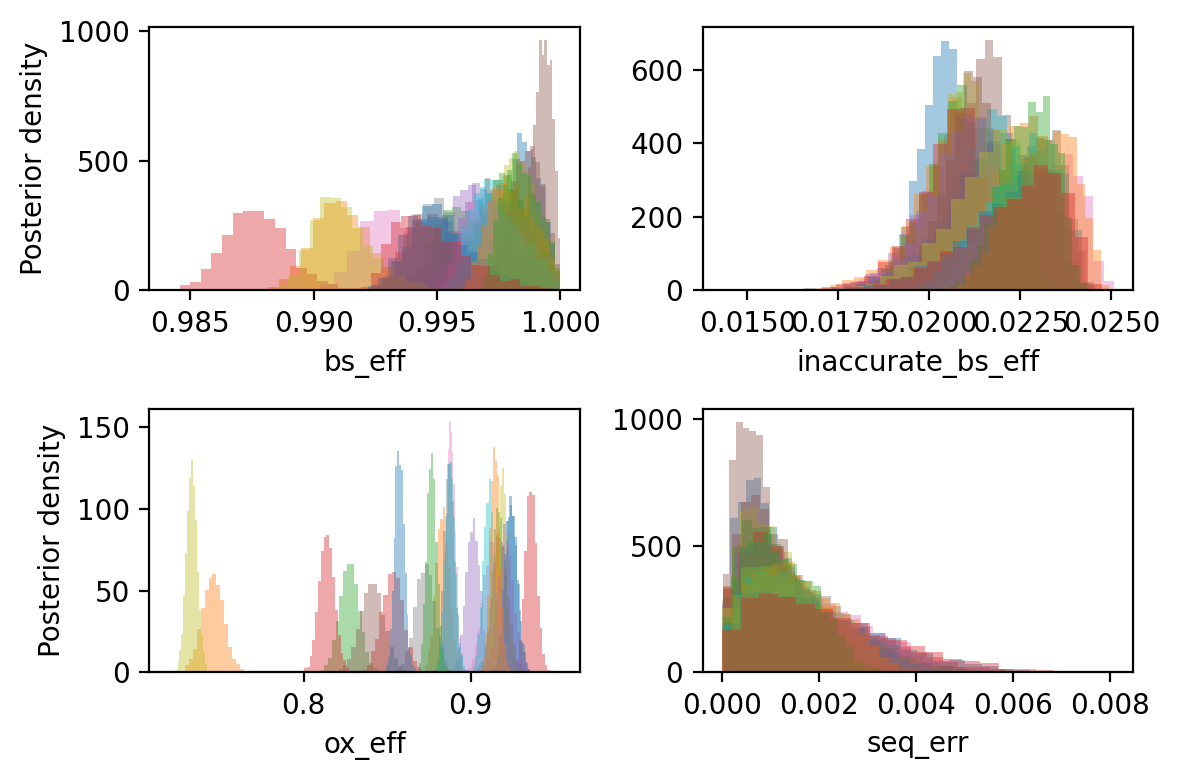

In [6]:
plot_experimental_parameters(lux_result);

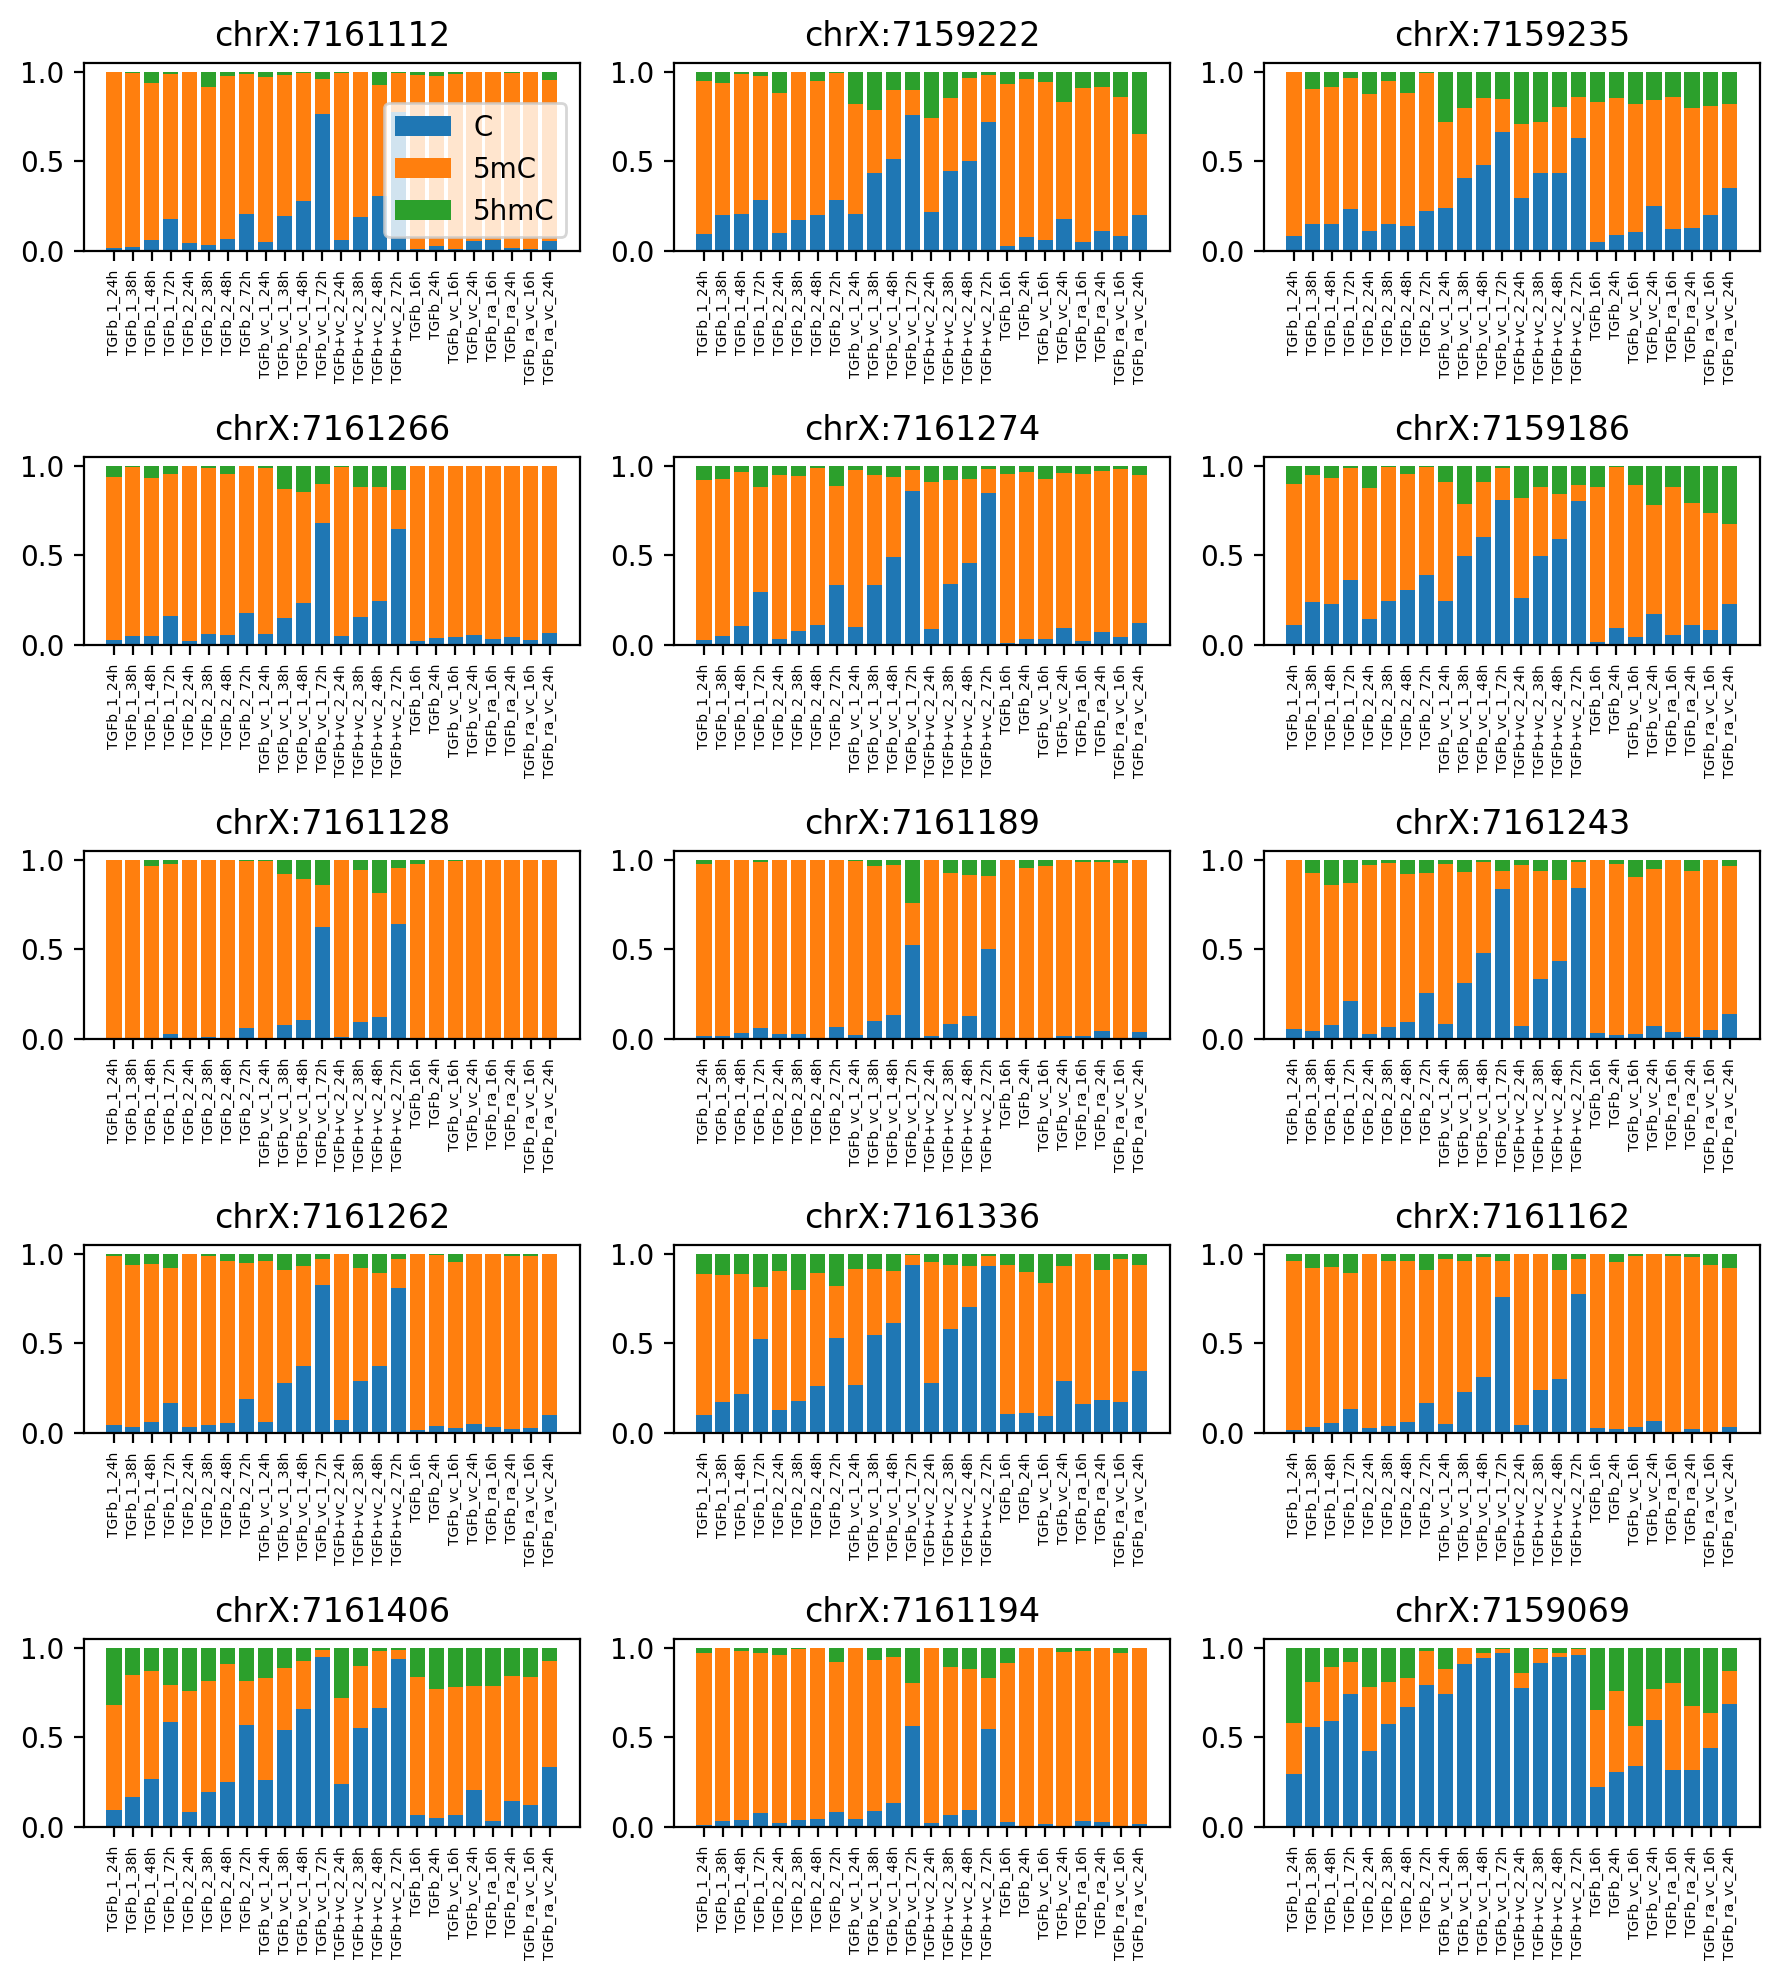

In [7]:
plot_methylation_levels(lux_result);

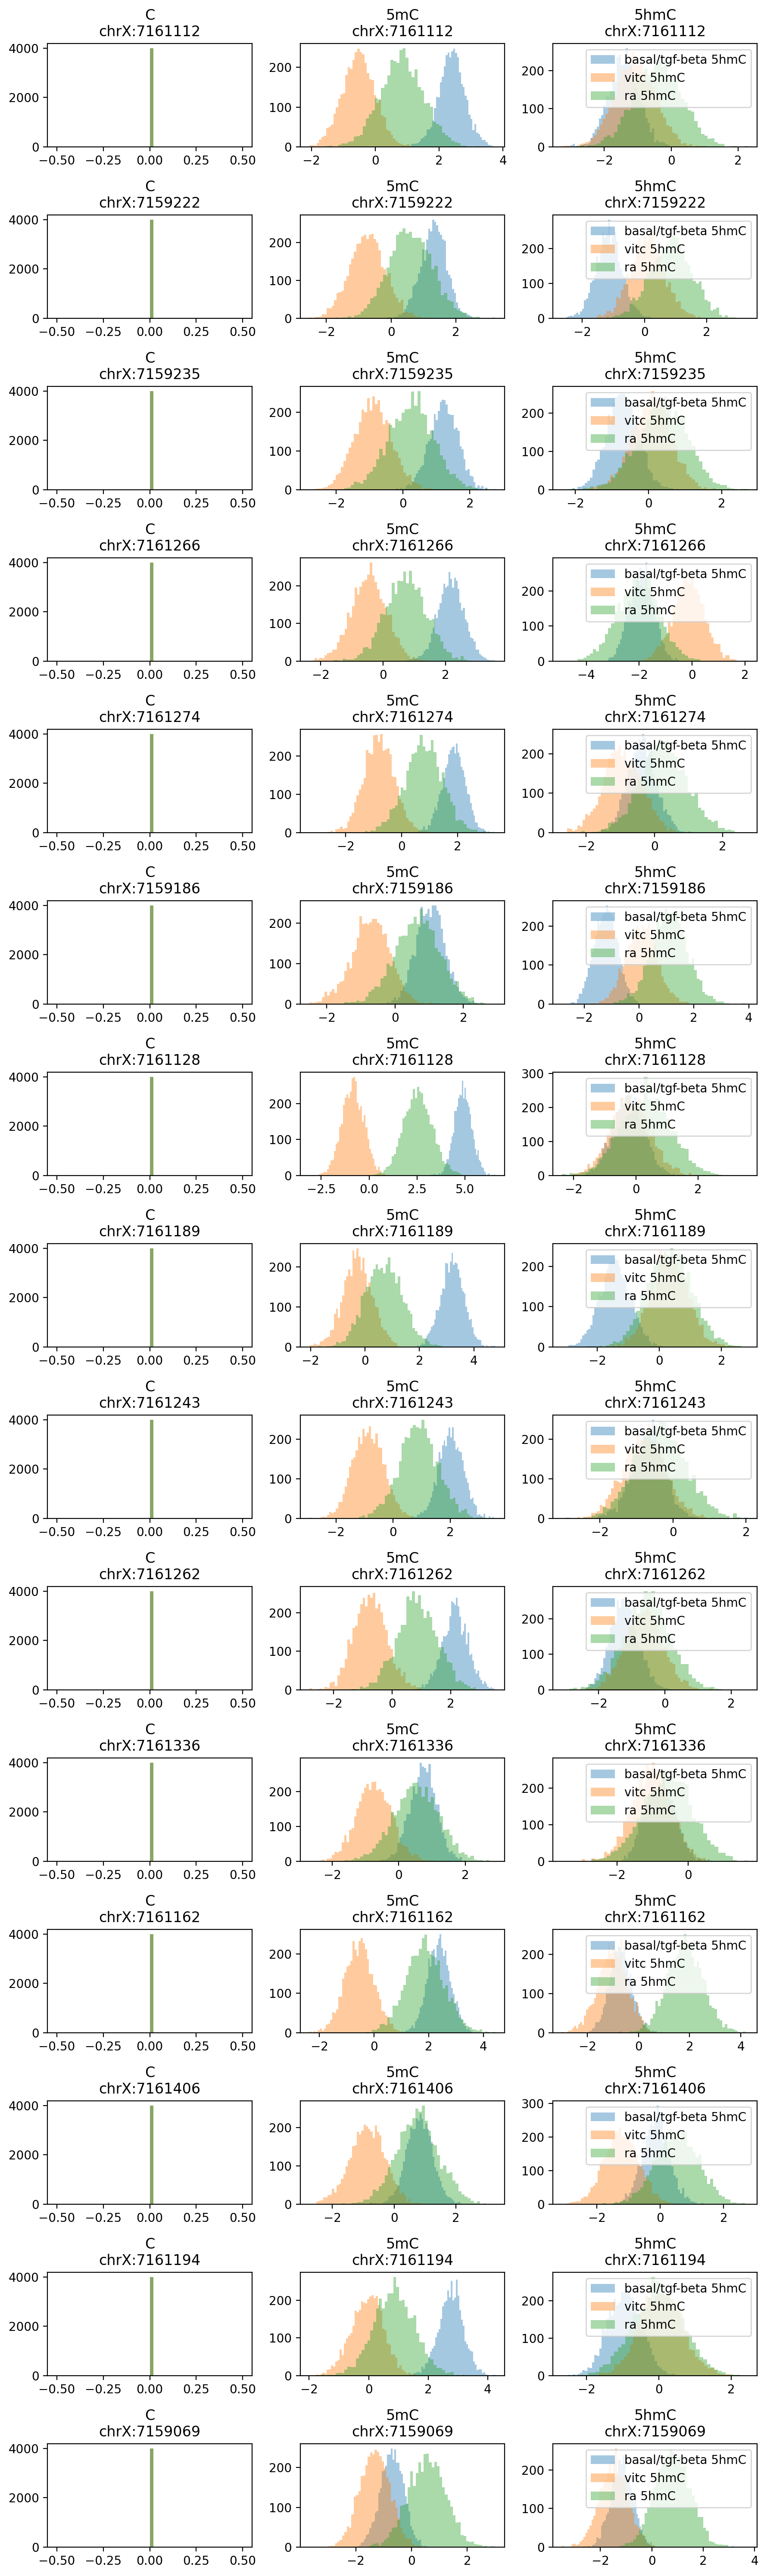

In [8]:
plot_coefficients(lux_result);

## Two-step estimation

1. estimate posterior distributions of experimental parameters using control cytosines
2. estimate posterior distributions of non-control cytosines


### Read input data


In [9]:
luxglm_input_data = get_input_data("metadata.tsv")

### Estimate posterior distributions


In [10]:
key, key_ = random.split(key)
lux_result_two_step = run_nuts(
    key,
    luxglm_input_data,
    ["basal/tgf-beta", "vitc", "ra"],
    num_warmup=1_000,
    num_samples=1_000,
    num_chains=4,
    two_steps_inference=True,
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

### Ensure convergence


In [11]:
display(lux_result_two_step.inference_metrics["summary_controls"].query("r_hat > 1.05"))
display(
    lux_result_two_step.inference_metrics["summary_noncontrols"].query("r_hat > 1.05")
)

,variable,index,mean,std,median,5.0%,95.0%,n_eff,r_hat


,variable,index,mean,std,median,5.0%,95.0%,n_eff,r_hat


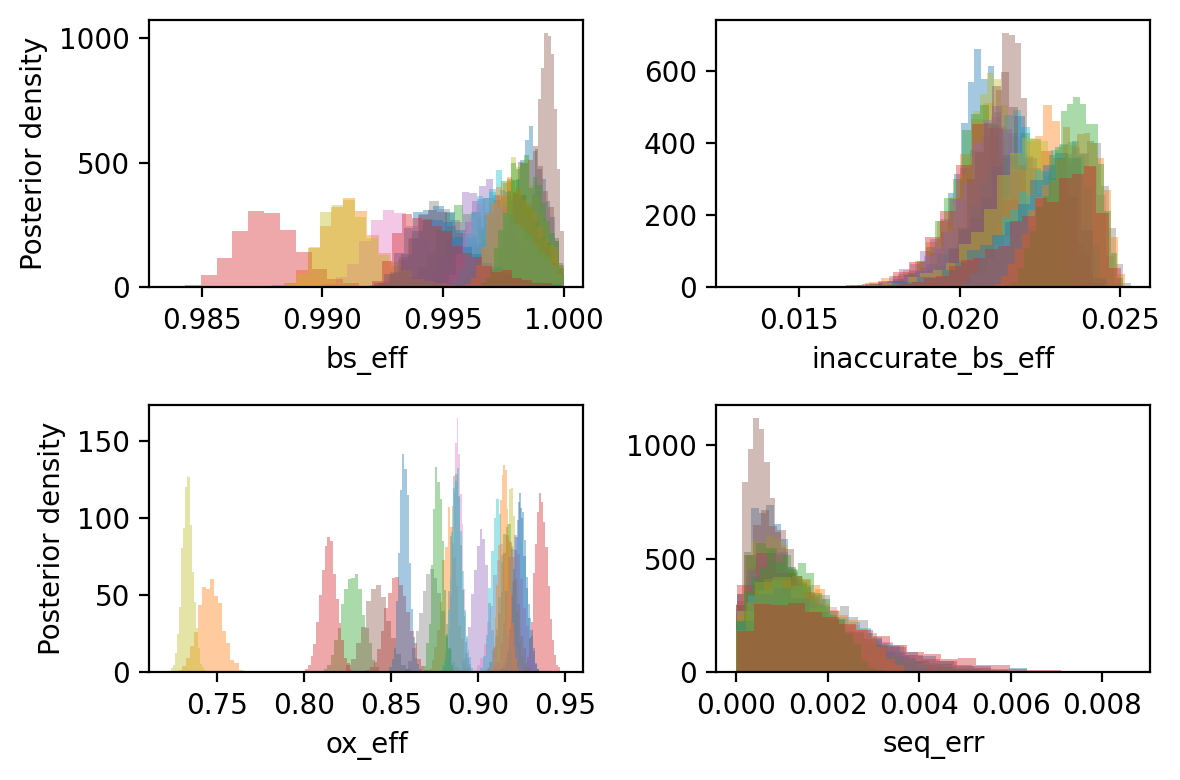

In [12]:
plot_experimental_parameters(lux_result_two_step);

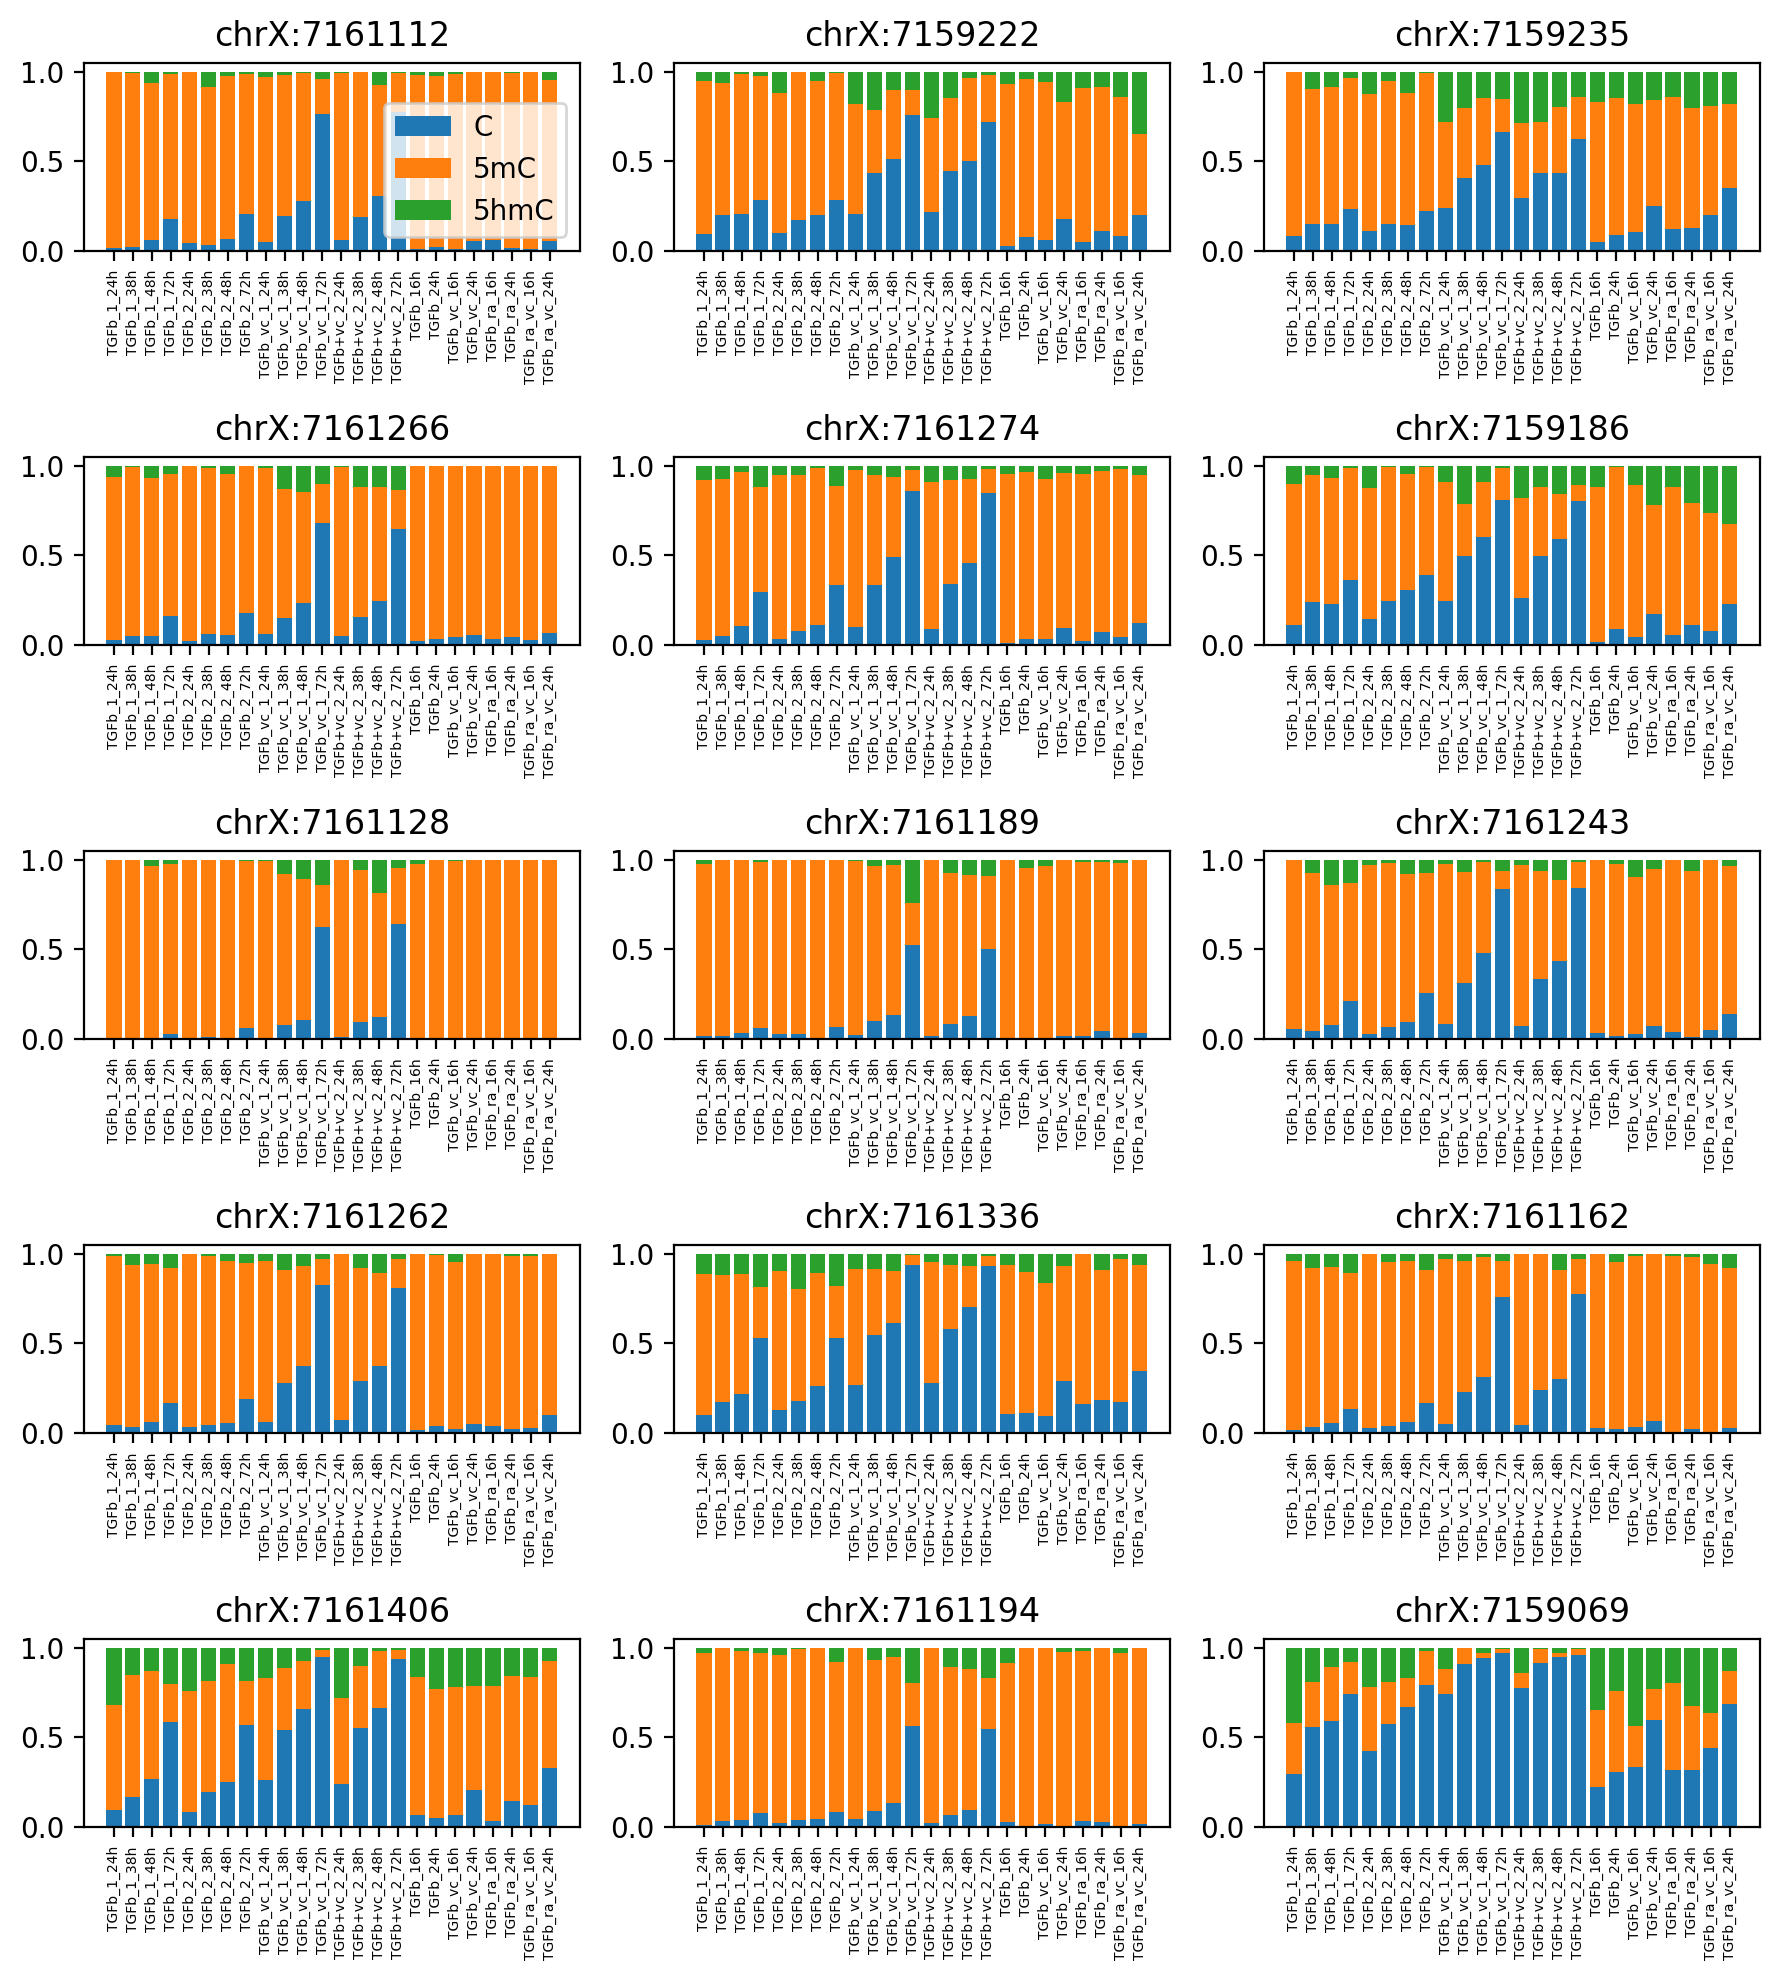

In [13]:
plot_methylation_levels(lux_result_two_step);

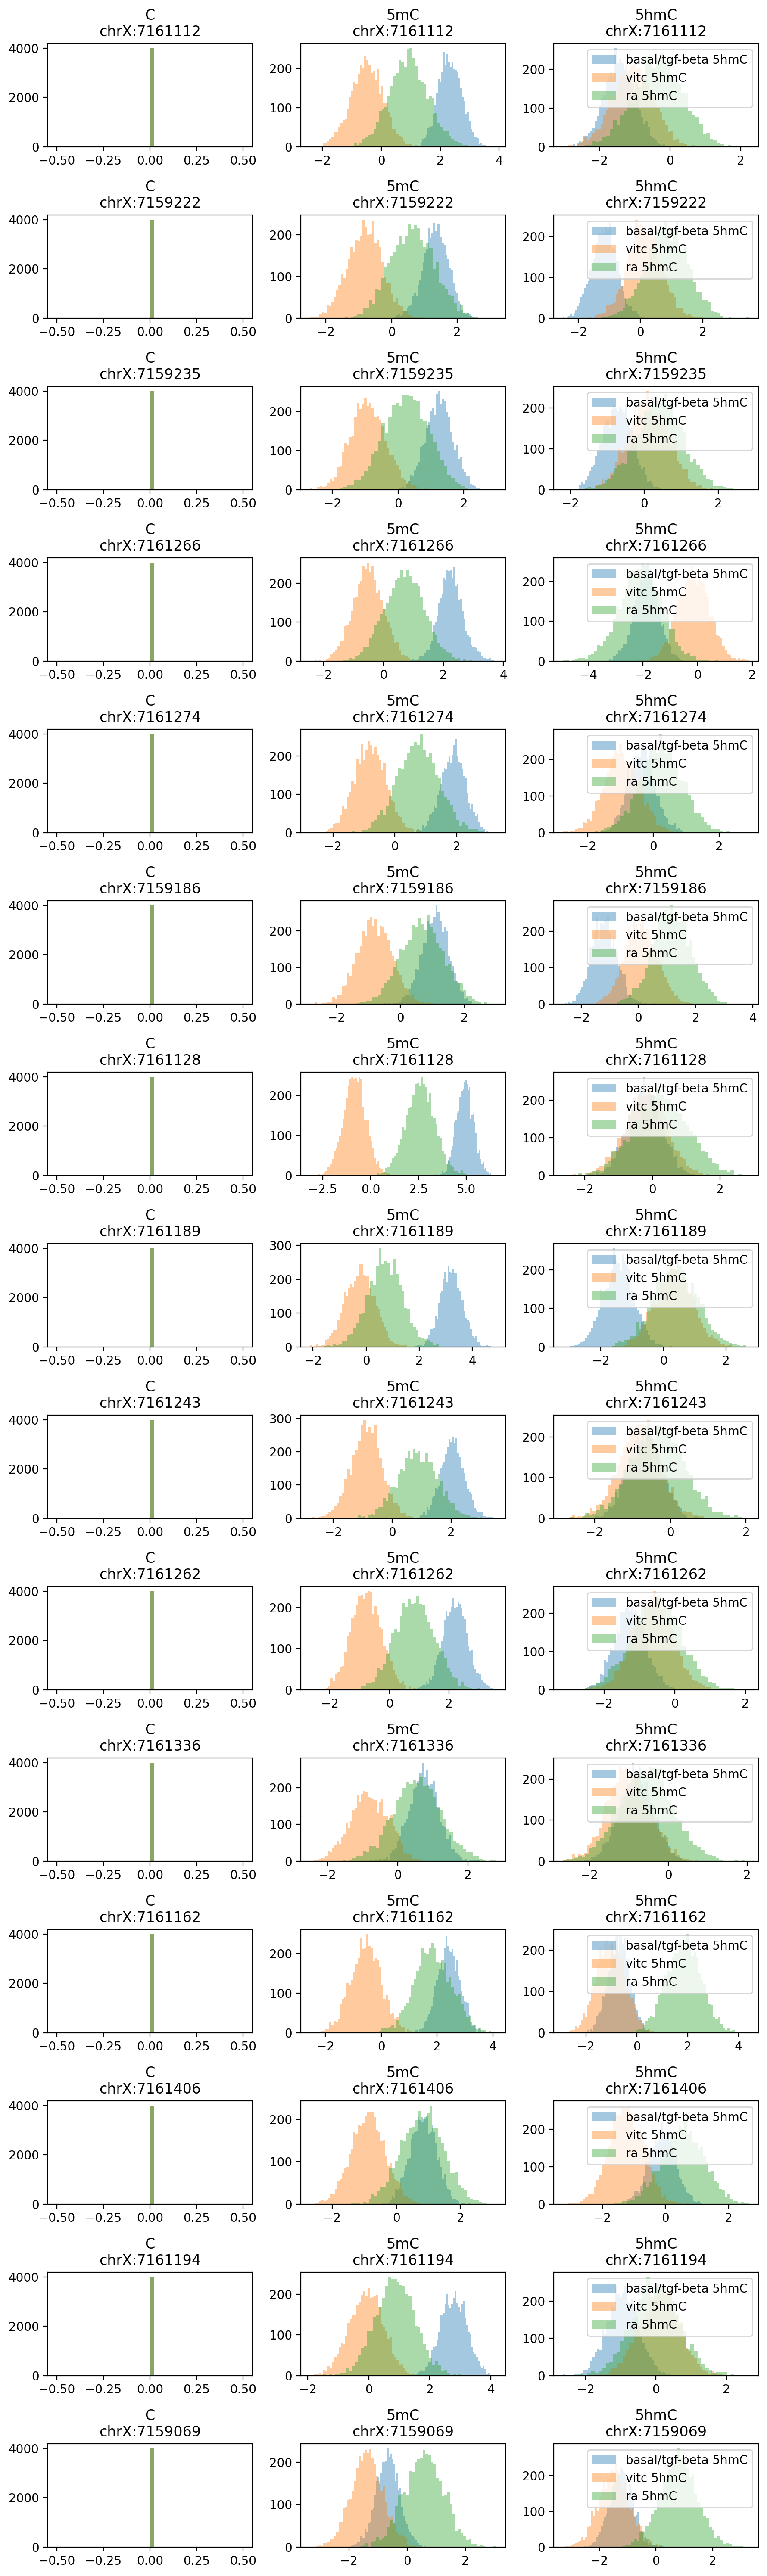

In [14]:
plot_coefficients(lux_result_two_step);